In [1]:
import os 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import anndata
from scipy import stats

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
def adata2numpy(adata):
    if sparse.issparse(adata.X):
        return adata.X.A
    else:
        return adata.X

In [4]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=15)

In [5]:
def calc_R2(adata, cell_type_key, cell_type, n_genes=6998, conditions=None):
    if n_genes != adata.shape[1]:
        adata_cell = adata[adata.obs[cell_type_key] == cell_type]
        print(adata_cell.obs["condition"].unique().tolist())
        sc.tl.rank_genes_groups(adata_cell, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = adata_cell.uns["rank_genes_groups"]["names"][conditions["real_stim"]].tolist()[:n_genes//2] \
                   + adata_cell.uns["rank_genes_groups"]["names"][conditions["ctrl"]].tolist()[:n_genes//2]
        adata = adata[:, diff_genes]
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
#     print(pred_stim)
#     print(real_stim)
#     for i in range(100):
#         pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
#         real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
#         pred_stim_data = adata2numpy(pred_stim)
#         real_stim_data = adata2numpy(real_stim)
#         x = np.average(pred_stim_data[pred_stim_idx], axis=0)
#         y = np.average(real_stim_data[real_stim_idx], axis=0)
#         m, b, r_value, p_value, std_err = stats.linregress(x, y)
#         r_values[0, i] = r_value ** 2
    pred_stim_data = adata2numpy(pred_stim)
    real_stim_data = adata2numpy(real_stim)
    x = np.asarray(np.mean(pred_stim_data, axis=0)).ravel()
    y = np.asarray(np.mean(real_stim_data, axis=0)).ravel()
    m, b, r_value, p_value, std_err = stats.linregress(x,y)
    r_values = r_value ** 2
    return r_values.mean(), r_values.std()

In [6]:
def calc_R2_mean_var(adata, data_name, cell_types, n_genes):
    r2_means, r2_vars = [], []
    for cell_type in cell_types:
        conditions = {"ctrl": f"{cell_type}_ctrl" ,"real_stim": f"{cell_type}_real", "pred_stim": f"{cell_type}_pred"}
        r2_mean, r2_var = calc_R2(adata, data_name, cell_type, n_genes=n_genes, conditions=conditions)
        r2_means.append(r2_mean)
        r2_vars.append(r2_var)
    return r2_means, r2_vars

In [7]:
def dotplot(adata, gene_list, model_name):
    sc.set_figure_params(fontsize=14)
    sc.pl.dotplot(adata, var_names=gene_list, groupby="condition", save= model_name + '.pdf', show=True)
    # os.rename(src=os.path.join(path_to_save, "dotplot.pdf"), dst=os.path.join(path_to_save, "Fig2f_dotplot.pdf"))

In [8]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=True, legend=False, offset=0.375, data_name = 'pbmc'):
    colors = ['#56B4E9', '#E69F00']
    plt.close("all")
#     import matplotlib
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=25)
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
    plt.figure(figsize=(16, 12))
    ax = plt.gca()
#     g = sns.catplot(x=cat, y=val, hue=subcat, data=df, kind='bar', palette="muted", height=6, legend=False)
#     g.despine(left=True)
#     plt.yticks(np.arange(0, 1.2, 0.2))
#     g.set_xticklabels(rotation=90)
#     g.set_xlabels("")
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
#         ax.text(x_popreds + i/1.25, dfg[val].values, f"{dfg[val].values}")
        b = ax.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values, color = colors[i])
        a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
#         print(a.shape)
#         dfc=pd.DataFrame({'x': x_pos + i/1.25, 'y': a[0]})
#         ax.text(x_pos + i/1.25, dfg[val].values, f"{dfg[val].values}")
        ax.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    plt.title(f"{data_name}_grouped_boxplot", fontsize = 40)
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=30)
    plt.xticks(x_pos+offset, u, rotation=90)
    ax.set_facecolor('white')
    ax.grid(False)
    ax.spines["left"].set_color("k")
    ax.spines["top"].set_color("k")
    ax.spines["bottom"].set_color("k")
    ax.spines["right"].set_color("k")
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join('figures','grouped_boxplot', filename), transparent=True, dpi=300)
    print("saved at:" + os.path.join('figures','grouped_boxplot', filename))
    plt.show()

In [11]:
def draw_csv(cell_types, data_name, keys):
    # train = sc.read('../data/train_' + model_name + '.h5ad')
    stim_key, ctrl_key, pred_key, cell_type_key = keys
    now = []
    for name in cell_types:
        adata = sc.read(os.path.join(f"scperb/{data_name}", 'model_' + name, "result.h5ad"))
        stim = adata[adata.obs["condition"] == stim_key]
        stim.obs['condition'] = f"{name}_real"

        # print(stim.obs['condition'])
        
        ctrl = adata[adata.obs["condition"] == ctrl_key]
        ctrl.obs['condition'] = f"{name}_ctrl"
        
        # print(ctrl.obs['condition'])

        pred = adata[adata.obs["condition"] == pred_key]
        pred.obs['condition'] = f"{name}_pred"

        # print(pred.obs['condition'])
        
        new_data = anndata.concat([stim, ctrl, pred])
        now.append(new_data)

    now = anndata.concat(now)

    # now.var_names = train.var_names

    print("finish pre data")

    r2_top100_means, r2_top100_vars = calc_R2_mean_var(now, cell_type_key, cell_types=cell_types, n_genes=100)

    print("finish top 100")

    r2_all_means, r2_all_vars = calc_R2_mean_var(now, cell_type_key, cell_types=cell_types, n_genes=now.shape[1])

    print("finish all genes")

    all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
    all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
    all_types = ["top 100 DEGs"] * len(r2_top100_means) + ["all genes"] * len(r2_top100_means)
    cell_types_x = 2 * cell_types
    print("draw_df:")
    df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})

    df.to_csv(os.path.join('figures/csvs', data_name + '.csv'))
    print("saved at: ", os.path.join('figures/csvs', data_name + '.csv'))

    all_means = np.concatenate((r2_top100_means, r2_all_means), axis=0)
    all_vars = np.concatenate((r2_top100_vars, r2_all_vars), axis=0)
    all_types = ["top 100 DEGs"] * len(cell_types) + ["all genes"] * len(cell_types)
    cell_types_x = 2 * cell_types
    df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Cell Types": cell_types_x})
    print(df[df["Type"] == "top 100 DEGs"])
    print(df[df["Type"] == "all genes"])
    sns.set()
    grouped_barplot(df, "Cell Types", "Type", "R^2 Means", "R^2 Stddevs", legend=True, filename=data_name + "_celltypes_barplots.pdf", data_name = data_name)
#     gene_list = ["CD3D", "CCL5", "GNLY", "CD79A", "FCGR3A", "S100A9", "HLA-DQA1", "ISG15", "IFI6", "IFIT1", "CXCL10", "CXCL11", "APOBEC3A", "DEFB1", "CCL8", "TARBP1"]
#     if model_name == 'pbmc':
#         dotplot(now, gene_list, model_name)

/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl.obs['condition'] = f"{name}_ctrl"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['condition'] = f"{name}_pred"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:13: ImplicitModificatio

finish pre data
['B_real', 'B_ctrl', 'B_pred']
['CD4T_real', 'CD4T_ctrl', 'CD4T_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['CD8T_real', 'CD8T_ctrl', 'CD8T_pred']
['CD14+Mono_real', 'CD14+Mono_ctrl', 'CD14+Mono_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['Dendritic_real', 'Dendritic_ctrl', 'Dendritic_pred']
['FCGR3A+Mono_real', 'FCGR3A+Mono_ctrl', 'FCGR3A+Mono_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['NK_real', 'NK_ctrl', 'NK_pred']
finish top 100


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


finish all genes
draw_df:
saved at:  figures/csvs/pbmc.csv
   R^2 Means  R^2 Stddevs          Type   Cell Types
0   0.978824          0.0  top 100 DEGs            B
1   0.997812          0.0  top 100 DEGs         CD4T
2   0.974178          0.0  top 100 DEGs         CD8T
3   0.992725          0.0  top 100 DEGs    CD14+Mono
4   0.986032          0.0  top 100 DEGs    Dendritic
5   0.996542          0.0  top 100 DEGs  FCGR3A+Mono
6   0.967495          0.0  top 100 DEGs           NK
    R^2 Means  R^2 Stddevs       Type   Cell Types
7    0.971850          0.0  all genes            B
8    0.994787          0.0  all genes         CD4T
9    0.966102          0.0  all genes         CD8T
10   0.991389          0.0  all genes    CD14+Mono
11   0.983985          0.0  all genes    Dendritic
12   0.995050          0.0  all genes  FCGR3A+Mono
13   0.946330          0.0  all genes           NK
saved at:figures/grouped_boxplot/pbmc_celltypes_barplots.pdf


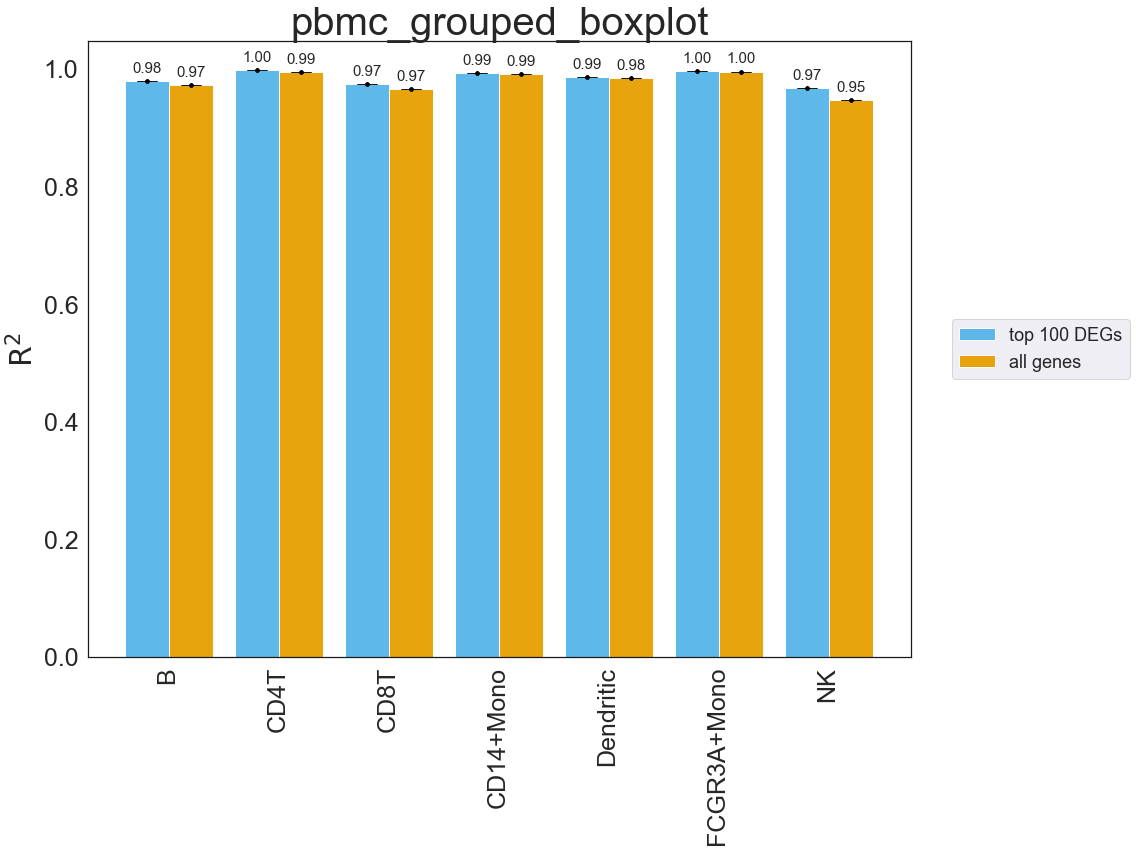

finish pbmc


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl.obs['condition'] = f"{name}_ctrl"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['condition'] = f"{name}_pred"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:13: ImplicitModificatio

finish pre data
['Endocrine_real', 'Endocrine_ctrl', 'Endocrine_pred']
['Enterocyte_real', 'Enterocyte_ctrl', 'Enterocyte_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['Enterocyte.Progenitor_real', 'Enterocyte.Progenitor_ctrl', 'Enterocyte.Progenitor_pred']
['Goblet_real', 'Goblet_ctrl', 'Goblet_pred']
['Stem_real', 'Stem_ctrl', 'Stem_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['TA_real', 'TA_ctrl', 'TA_pred']
['TA.Early_real', 'TA.Early_ctrl', 'TA.Early_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['Tuft_real', 'Tuft_ctrl', 'Tuft_pred']
finish top 100
finish all genes
draw_df:
saved at:  figures/csvs/hpoly.csv
   R^2 Means  R^2 Stddevs          Type             Cell Types
0   0.858699          0.0  top 100 DEGs              Endocrine
1   0.950318          0.0  top 100 DEGs             Enterocyte
2   0.976195          0.0  top 100 DEGs  Enterocyte.Progenitor
3   0.975156          0.0  top 100 DEGs                 Goblet
4   0.986459          0.0  top 100 DEGs                   Stem
5   0.981389          0.0  top 100 DEGs                     TA
6   0.962790          0.0  top 100 DEGs               TA.Early
7   0.957905          0.0  top 100 DEGs                   Tuft
    R^2 Means  R^2 Stddevs       Type             Cell Types
8    0.865065          0.0  all genes              Endocrine
9    0.953661          0.0  all genes             Enterocyte
10   0.979755          0.0  all genes  Enterocyte.Progenitor
11   0.977795          0.0  all genes                 Goblet
12   0.986471

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


saved at:figures/grouped_boxplot/hpoly_celltypes_barplots.pdf


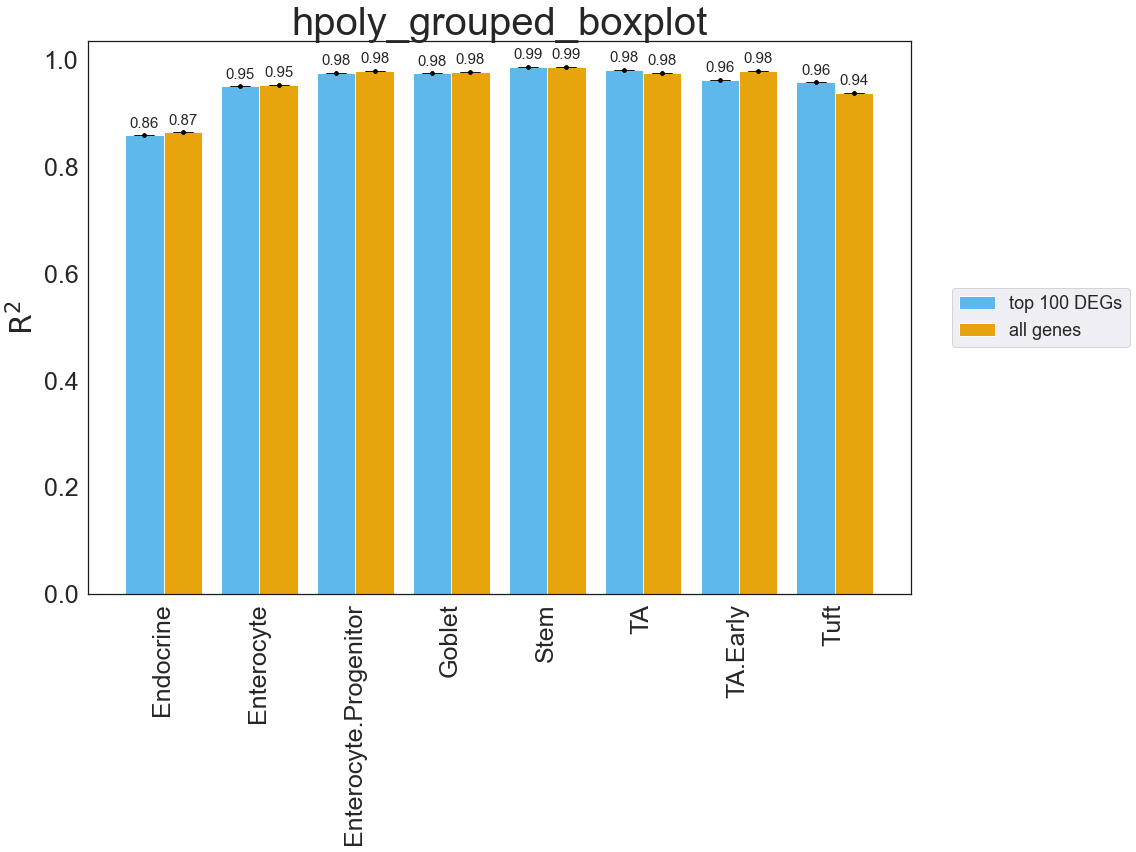

finish hpoly


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl.obs['condition'] = f"{name}_ctrl"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pred.obs['condition'] = f"{name}_pred"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stim.obs['condition'] = f"{name}_real"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_66025/3266467240.py:13: ImplicitModificatio

finish pre data
['B_real', 'B_ctrl', 'B_pred']
['CD4T_real', 'CD4T_ctrl', 'CD4T_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['CD8T_real', 'CD8T_ctrl', 'CD8T_pred']
['CD14+Mono_real', 'CD14+Mono_ctrl', 'CD14+Mono_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['Dendritic_real', 'Dendritic_ctrl', 'Dendritic_pred']
['FCGR3A+Mono_real', 'FCGR3A+Mono_ctrl', 'FCGR3A+Mono_pred']


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['NK_real', 'NK_ctrl', 'NK_pred']
finish top 100


/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


finish all genes
draw_df:
saved at:  figures/csvs/study.csv
   R^2 Means  R^2 Stddevs          Type   Cell Types
0   0.987960          0.0  top 100 DEGs            B
1   0.988750          0.0  top 100 DEGs         CD4T
2   0.937496          0.0  top 100 DEGs         CD8T
3   0.994915          0.0  top 100 DEGs    CD14+Mono
4   0.982509          0.0  top 100 DEGs    Dendritic
5   0.986015          0.0  top 100 DEGs  FCGR3A+Mono
6   0.977135          0.0  top 100 DEGs           NK
    R^2 Means  R^2 Stddevs       Type   Cell Types
7    0.982146          0.0  all genes            B
8    0.990489          0.0  all genes         CD4T
9    0.959960          0.0  all genes         CD8T
10   0.990486          0.0  all genes    CD14+Mono
11   0.982604          0.0  all genes    Dendritic
12   0.987635          0.0  all genes  FCGR3A+Mono
13   0.973917          0.0  all genes           NK
saved at:figures/grouped_boxplot/study_celltypes_barplots.pdf


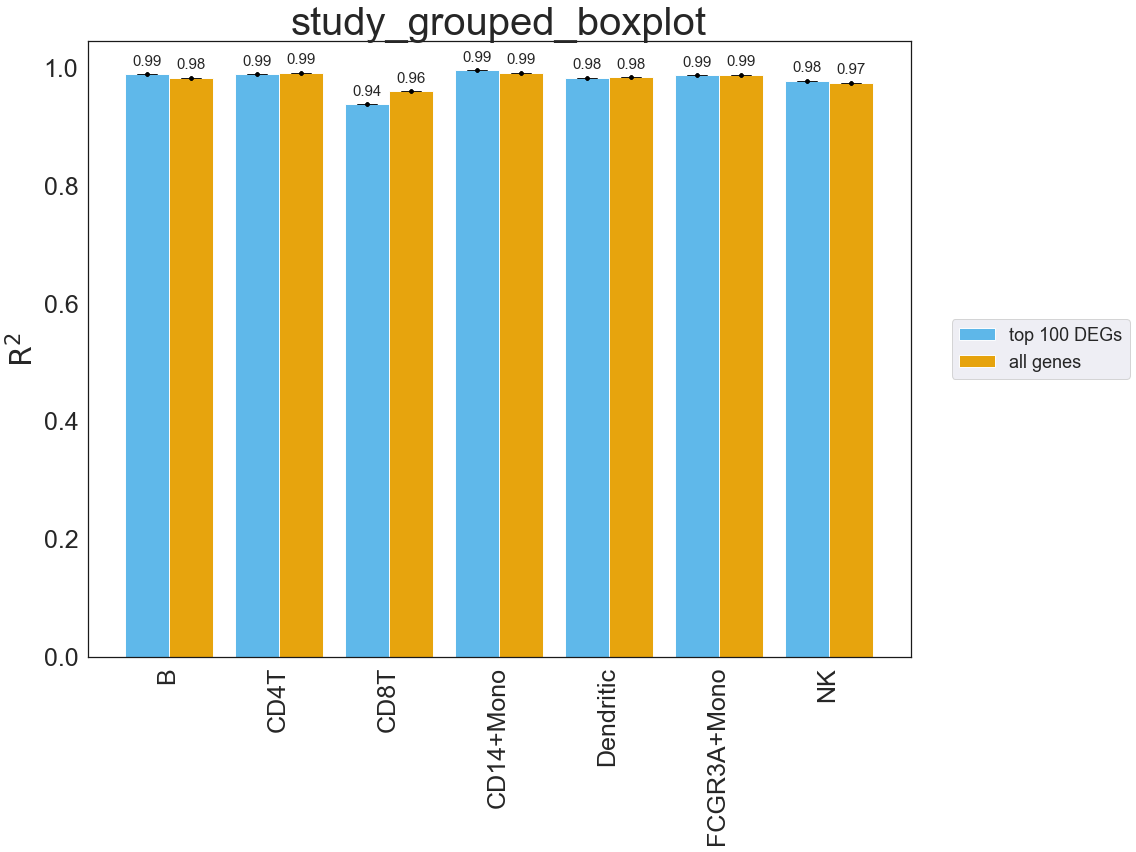

finish study


In [12]:
name_pbmc = ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK']
name_hpoly = ['Endocrine', 'Enterocyte', 'Enterocyte.Progenitor', 'Goblet', 'Stem', 'TA', 'TA.Early', 'Tuft']
name_study = ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK']
key_pbmc = ['stimulated', 'control', 'pred', 'cell_type']
key_hpoly = ['Hpoly.Day10', 'Control', 'pred', 'cell_label']
key_study = ['stimulated', 'control', 'pred', 'cell_type']
draw_csv(name_pbmc, "pbmc", key_pbmc)
print("finish pbmc")
draw_csv(name_hpoly, 'hpoly', key_hpoly)
print("finish hpoly")
draw_csv(name_study, 'study', key_study)
print("finish study")